# Разработка и обучение моделей для прогноза модуля упругости при растяжении и прочности при растяжении

In [25]:
# Импортируем необходимые библиотеки(сразу все)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error
import pickle
from tabulate import tabulate
!pip install tabulate


In [2]:
# Загрузка данных
df = pd.read_csv('VKR.csv')

In [3]:
# Разделение на признаки и целевые переменные
x_pr = df.drop(['Прочность при растяжении, МПа'], axis=1)
y_pr = df['Прочность при растяжении, МПа']
x_mu = df.drop(['Модуль упругости при растяжении, ГПа'], axis=1)
y_mu = df['Модуль упругости при растяжении, ГПа']


In [4]:
# Разделение на обучающую и тестовую выборки
X_train_pr, X_test_pr, y_train_pr, y_test_pr = train_test_split(x_pr, y_pr, test_size=0.3, random_state=1)
X_train_mu, X_test_mu, y_train_mu, y_test_mu = train_test_split(x_mu, y_mu, test_size=0.3, random_state=1)


In [5]:
# Списки для сохранения результатов
r2_pr, mse_pr, r2_mu, mse_mu = [], [], [], []


### Линейная регрессия

In [6]:
print("Линейная регрессия:")
lm = LinearRegression()
lm.fit(X_train_pr, y_train_pr)
y_pred_pr = lm.predict(X_test_pr)
r2_pr.append(r2_score(y_test_pr, y_pred_pr))
mse_pr.append(mean_squared_error(y_test_pr, y_pred_pr))

lm = LinearRegression()
lm.fit(X_train_mu, y_train_mu)
y_pred_mu = lm.predict(X_test_mu)
r2_mu.append(r2_score(y_test_mu, y_pred_mu))
mse_mu.append(mean_squared_error(y_test_mu, y_pred_mu))
print("Прочность при растяжении - R2: {:.4f}, MSE: {:.4f}".format(r2_pr[-1], mse_pr[-1]))
print("Модуль упругости при растяжении - R2: {:.4f}, MSE: {:.4f}".format(r2_mu[-1], mse_mu[-1]))


Линейная регрессия:
Прочность при растяжении - R2: -0.0325, MSE: 0.0329
Модуль упругости при растяжении - R2: -0.0024, MSE: 0.0259


Значения R2 и MSE используются для оценки качества предсказаний модели. R2 (коэффициент детерминации) указывает на то, насколько хорошо модель подходит для описания данных и может принимать значения от 0 до 1, где 1 означает идеальное соответствие модели данным. Значение R2 отрицательное означает, что модель не подходит для описания данных.

MSE (среднеквадратичная ошибка) показывает, насколько сильно отличаются предсказанные значения от фактических значений. Чем меньше значение MSE, тем лучше модель.

В данном случае значения R2 и MSE для обеих моделей (прочности при растяжении и модуля упругости) находятся в неудовлетворительном диапазоне, что говорит о том, что линейная регрессия не подходит для описания этих данных.

### Lasso

In [7]:
print("Lasso:")
lasso = Lasso()
parameters = {'alpha': [0.01, 0.1, 1, 10]}
lasso_cv = GridSearchCV(lasso, parameters,
cv=10, scoring='neg_mean_squared_error')
lasso_cv.fit(X_train_pr, y_train_pr)
y_pred_pr = lasso_cv.predict(X_test_pr)
r2_pr.append(r2_score(y_test_pr, y_pred_pr))
mse_pr.append(mean_squared_error(y_test_pr, y_pred_pr))

lasso_cv.fit(X_train_mu, y_train_mu)
y_pred_mu = lasso_cv.predict(X_test_mu)
r2_mu.append(r2_score(y_test_mu, y_pred_mu))
mse_mu.append(mean_squared_error(y_test_mu, y_pred_mu))
print("Прочность при растяжении - Lasso")
print(f"Лучший гиперпараметр: {lasso_cv.best_params_}")
print("R2: {:.4f}, MSE: {:.4f}".format(r2_pr[-1], mse_pr[-1]))
print("Модуль упругости при растяжении - Lasso")
print(f"Лучший гиперпараметр: {lasso_cv.best_params_}")
print("R2: {:.4f}, MSE: {:.4f}".format(r2_mu[-1], mse_mu[-1]))

Lasso:
Прочность при растяжении - Lasso
Лучший гиперпараметр: {'alpha': 0.01}
R2: -0.0021, MSE: 0.0319
Модуль упругости при растяжении - Lasso
Лучший гиперпараметр: {'alpha': 0.01}
R2: -0.0006, MSE: 0.0259


Lasso - это метод регрессии, который добавляет штраф на коэффициенты модели, чтобы уменьшить их влияние и избежать переобучения. В данном случае, на основе результатов вычислений, можно сделать вывод, что Lasso не привнес значительного улучшения в сравнении с линейной регрессией. Значения коэффициента детерминации R2 и среднеквадратической ошибки MSE примерно такие же или хуже, чем в случае линейной регрессии. Лучший гиперпараметр для обоих моделей - значение alpha равное 0.01.

### k ближайших соседей

In [8]:
knn = KNeighborsRegressor()
parameters = {'n_neighbors': [5, 10, 20, 30]}
knn_cv = GridSearchCV(knn, parameters,
cv=10, scoring='neg_mean_squared_error')
knn_cv.fit(X_train_pr, y_train_pr)
y_pred_pr = knn_cv.predict(X_test_pr)
r2_pr.append(r2_score(y_test_pr, y_pred_pr))
mse_pr.append(mean_squared_error(y_test_pr, y_pred_pr))

knn_cv.fit(X_train_mu, y_train_mu)
y_pred_mu = knn_cv.predict(X_test_mu)
r2_mu.append(r2_score(y_test_mu, y_pred_mu))
mse_mu.append(mean_squared_error(y_test_mu, y_pred_mu))
print("Прочность при растяжении - k ближайших соседей")
print(f"Лучший гиперпараметр: {knn_cv.best_params_}")
print("R2: {:.4f}, MSE: {:.4f}".format(r2_pr[-1], mse_pr[-1]))
print("Модуль упругости при растяжении - k ближайших соседей")
print("R2: {:.4f}, MSE: {:.4f}".format(r2_mu[-1], mse_mu[-1]))

Прочность при растяжении - k ближайших соседей
Лучший гиперпараметр: {'n_neighbors': 30}
R2: 0.0094, MSE: 0.0316
Модуль упругости при растяжении - k ближайших соседей
R2: -0.0093, MSE: 0.0261


Для прочности при растяжении R2 равен 0.0094, что говорит о том, что модель K ближайших соседей дает небольшой положительный вклад в объяснение вариации в прочности при растяжении. MSE для этой модели равен 0.0316, что указывает на среднеквадратичную ошибку модели в прогнозировании прочности при растяжении.

Для модуля упругости при растяжении R2 равен -0.0093, что говорит о том, что модель K ближайших соседей не способна объяснить вариацию в модуле упругости при растяжении. MSE для этой модели равен 0.0261, что указывает на среднеквадратичную ошибку модели в прогнозировании модуля упругости при растяжении.

Таким образом, можно сделать вывод, что модель K ближайших соседей дает небольшой вклад в прогнозирование прочности при растяжении, но не является хорошей моделью для прогнозирования модуля упругости при растяжении.

### Решающее дерево

In [9]:
tree = DecisionTreeRegressor(random_state=42)
parameters = {'max_depth': [5, 10, 15, 20]}
tree_cv = GridSearchCV(tree, parameters,
cv=10, scoring='neg_mean_squared_error')
tree_cv.fit(X_train_pr, y_train_pr)
y_pred_pr = tree_cv.predict(X_test_pr)
r2_pr.append(r2_score(y_test_pr, y_pred_pr))
mse_pr.append(mean_squared_error(y_test_pr, y_pred_pr))

tree_cv.fit(X_train_mu, y_train_mu)
y_pred_mu = tree_cv.predict(X_test_mu)
r2_mu.append(r2_score(y_test_mu, y_pred_mu))
mse_mu.append(mean_squared_error(y_test_mu, y_pred_mu))
print("Прочность при растяжении - решающее дерево")
print(f"Лучший гиперпараметр: {tree_cv.best_params_}")
print("R2: {:.4f}, MSE: {:.4f}".format(r2_pr[-1], mse_pr[-1]))
print("Модуль упругости при растяжении - решающее дерево")
print("R2: {:.4f}, MSE: {:.4f}".format(r2_mu[-1], mse_mu[-1]))

Прочность при растяжении - решающее дерево
Лучший гиперпараметр: {'max_depth': 5}
R2: -0.2770, MSE: 0.0407
Модуль упругости при растяжении - решающее дерево
R2: -0.1028, MSE: 0.0285


Модель решающего дерева также имеет отрицательный коэффициент детерминации и высокую среднеквадратическую ошибку, что указывает на низкую точность модели.

### Стохастический градиентный спуск

In [10]:
sgd = SGDRegressor(random_state=42)
parameters = {'max_iter': [1000, 5000, 10000],
'penalty': ['l1', 'l2']}
sgd_cv = GridSearchCV(sgd, parameters,
cv=10, scoring='neg_mean_squared_error')
sgd_cv.fit(X_train_pr, y_train_pr)
y_pred_pr = sgd_cv.predict(X_test_pr)
r2_pr.append(r2_score(y_test_pr, y_pred_pr))
mse_pr.append(mean_squared_error(y_test_pr, y_pred_pr))

sgd_cv.fit(X_train_mu, y_train_mu)
y_pred_mu = sgd_cv.predict(X_test_mu)
r2_mu.append(r2_score(y_test_mu, y_pred_mu))
mse_mu.append(mean_squared_error(y_test_mu, y_pred_mu))
print("Прочность при растяжении - Стохастический градиентный спуск")
print(f"Лучший гиперпараметр: {sgd_cv.best_params_}")
print(f"R2: {r2_pr[-1]:.4f}, MSE: {mse_pr[-1]:.4f}")
print(f"Модуль упругости при растяжении - Стохастический градиентный спуск")
print(f"Лучший гиперпараметр: {sgd_cv.best_params_}")
print(f"R2: {r2_mu[-1]:.4f}, MSE: {mse_mu[-1]:.4f}")

Прочность при растяжении - Стохастический градиентный спуск
Лучший гиперпараметр: {'max_iter': 1000, 'penalty': 'l1'}
R2: -0.0503, MSE: 0.0335
Модуль упругости при растяжении - Стохастический градиентный спуск
Лучший гиперпараметр: {'max_iter': 1000, 'penalty': 'l1'}
R2: -0.0302, MSE: 0.0266


Из результатов можно сделать вывод, что ни одна из моделей не показала хороших результатов при предсказании прочности при растяжении и модуля упругости при растяжении. В частности, все значения коэффициента детерминации (R2) отрицательны, что указывает на то, что модели не могут объяснить дисперсию данных. Также значения среднеквадратической ошибки (MSE) высоки, что говорит о том, что модели не могут достаточно точно предсказывать значения целевых переменных.

### Метод опорных векторов

In [11]:
svm = SVR()
parameters = {'kernel': ['linear', 'rbf', 'poly'],
'C': [0.1, 1, 10]}
svm_cv = GridSearchCV(svm, parameters,
cv=10, scoring='neg_mean_squared_error')
svm_cv.fit(X_train_pr, y_train_pr)
y_pred_pr = svm_cv.predict(X_test_pr)
r2_pr.append(r2_score(y_test_pr, y_pred_pr))
mse_pr.append(mean_squared_error(y_test_pr, y_pred_pr))

svm_cv.fit(X_train_mu, y_train_mu)
y_pred_mu = svm_cv.predict(X_test_mu)
r2_mu.append(r2_score(y_test_mu, y_pred_mu))
mse_mu.append(mean_squared_error(y_test_mu, y_pred_mu))
print("Прочность при растяжении - Метод опорных векторов")
print(f"Лучший гиперпараметр: {svm_cv.best_params_}")
print(f"R^2 на тестовом наборе: {r2_score(y_test_pr, y_pred_pr)}")
print(f"Среднеквадратическая ошибка на тестовом наборе: {mean_squared_error(y_test_pr, y_pred_pr)}")

print("Упругость - Метод опорных векторов")
print(f"Лучший гиперпараметр: {svm_cv.best_params_}")
print(f"R^2 на тестовом наборе: {r2_score(y_test_mu, y_pred_mu)}")
print(f"Среднеквадратическая ошибка на тестовом наборе: {mean_squared_error(y_test_mu, y_pred_mu)}")

Прочность при растяжении - Метод опорных векторов
Лучший гиперпараметр: {'C': 0.1, 'kernel': 'linear'}
R^2 на тестовом наборе: -0.03207455479267929
Среднеквадратическая ошибка на тестовом наборе: 0.03288549088051893
Упругость - Метод опорных векторов
Лучший гиперпараметр: {'C': 0.1, 'kernel': 'linear'}
R^2 на тестовом наборе: -0.0024923920654420506
Среднеквадратическая ошибка на тестовом наборе: 0.025910690721890742


### Метод случайного леса

In [14]:
rf = RandomForestRegressor()

parameters = {'n_estimators': [100, 500, 1000],
              'max_depth': [None, 10, 50],
              'max_features': ['auto', 'sqrt']}
rf_cv = GridSearchCV(rf, parameters, cv=10, scoring='neg_mean_squared_error')
rf_cv.fit(X_train_pr, y_train_pr)
y_pred_pr = rf_cv.predict(X_test_pr)
r2_pr.append(r2_score(y_test_pr, y_pred_pr))
mse_pr.append(mean_squared_error(y_test_pr, y_pred_pr))

rf_cv.fit(X_train_mu, y_train_mu)
y_pred_mu = rf_cv.predict(X_test_mu)
r2_mu.append(r2_score(y_test_mu, y_pred_mu))
mse_mu.append(mean_squared_error(y_test_mu, y_pred_mu))
print("Прочность при растяжении - Случайный лес")
print(f"Лучший гиперпараметр: {rf_cv.best_params_}")
print(f"R^2 на тестовом наборе: {r2_score(y_test_pr, y_pred_pr)}")
print(f"Среднеквадратическая ошибка на тестовом наборе: {mean_squared_error(y_test_pr, y_pred_pr)}")

print("Упругость - Случайный лес")
print(f"Лучший гиперпараметр: {rf_cv.best_params_}")
print(f"R^2 на тестовом наборе: {r2_score(y_test_mu, y_pred_mu)}")
print(f"Среднеквадратическая ошибка на тестовом наборе: {mean_squared_error(y_test_mu, y_pred_mu)}")

Прочность при растяжении - Случайный лес
Лучший гиперпараметр: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 1000}
R^2 на тестовом наборе: -0.028642917893767272
Среднеквадратическая ошибка на тестовом наборе: 0.03277614697370487
Упругость - Случайный лес
Лучший гиперпараметр: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 1000}
R^2 на тестовом наборе: 0.0004623552863239899
Среднеквадратическая ошибка на тестовом наборе: 0.0258343215190929


In [24]:
# Создаем словарь с результатами для прочности при растяжении
results_pr = {'Model': ['Linear Regression','Lasso', 'KNeighborsRegressor', 'Decision Tree Regression','SGDRegressor', 'Support Vector Regression', 'Random Forest Regression'],
              'R^2': r2_pr, 'MSE': mse_pr}

# Создаем DataFrame из словаря
df_pr = pd.DataFrame(results_pr)

# Создаем словарь с результатами для упругости
results_mu = {'Model': ['Linear Regression','Lasso', 'KNeighborsRegressor', 'Decision Tree Regression','SGDRegressor', 'Support Vector Regression', 'Random Forest Regression'],
              'R^2': r2_mu, 'MSE': mse_mu}

# Создаем DataFrame из словаря
df_mu = pd.DataFrame(results_mu)

# Создаем таблицу для прочности при растяжении
table_pr = tabulate(df_pr, headers='keys', tablefmt='fancy_grid')

# Создаем таблицу для упругости
table_mu = tabulate(df_mu, headers='keys', tablefmt='fancy_grid')

# Выводим таблицы
print('Результаты прочности при растяжении:\n')
print(table_pr)
print('\n\nРезультаты для упругости:\n')
print(table_mu)


╒════╤═══════════════════════════╤═════════════╤═══════════╕
│    │ Model                     │         R^2 │       MSE │
╞════╪═══════════════════════════╪═════════════╪═══════════╡
│  0 │ Linear Regression         │ -0.0325385  │ 0.0329003 │
├────┼───────────────────────────┼─────────────┼───────────┤
│  1 │ Lasso                     │ -0.0021228  │ 0.0319311 │
├────┼───────────────────────────┼─────────────┼───────────┤
│  2 │ KNeighborsRegressor       │  0.00936454 │ 0.0315651 │
├────┼───────────────────────────┼─────────────┼───────────┤
│  3 │ Decision Tree Regression  │ -0.276967   │ 0.0406886 │
├────┼───────────────────────────┼─────────────┼───────────┤
│  4 │ SGDRegressor              │ -0.050316   │ 0.0334667 │
├────┼───────────────────────────┼─────────────┼───────────┤
│  5 │ Support Vector Regression │ -0.0320746  │ 0.0328855 │
├────┼───────────────────────────┼─────────────┼───────────┤
│  6 │ Random Forest Regression  │ -0.0286429  │ 0.0327761 │
╘════╧═════════════════

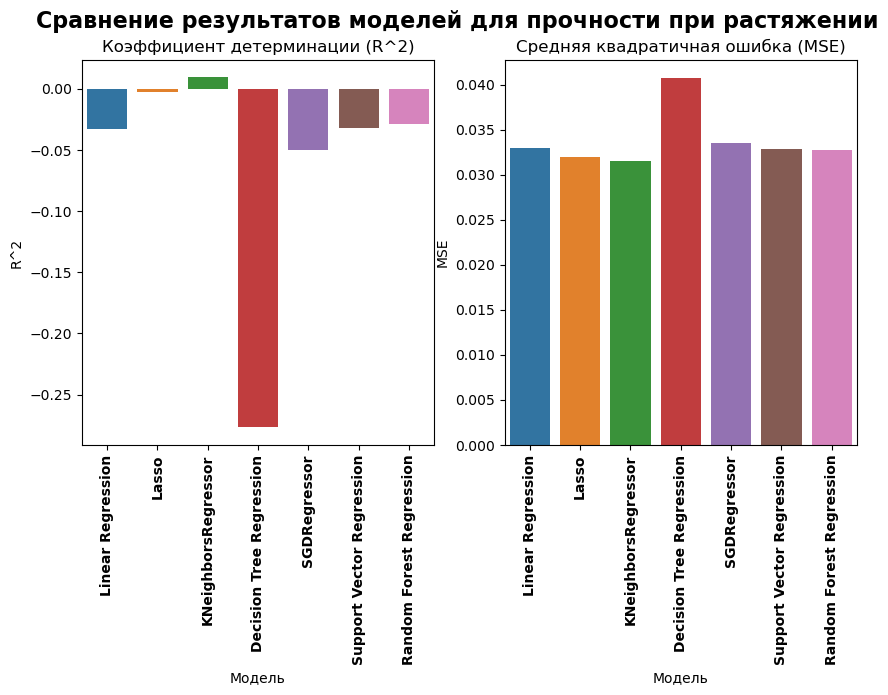

In [31]:
# Визуализируем результат
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# График R^2
sns.barplot(x='Model', y='R^2', data=df_pr, ax=axes[0])
axes[0].set_title('Коэффициент детерминации (R^2)')
axes[0].set_xlabel('Модель')
axes[0].set_ylabel('R^2')

# График MSE
sns.barplot(x='Model', y='MSE', data=df_pr, ax=axes[1])
axes[1].set_title('Средняя квадратичная ошибка (MSE)')
axes[1].set_xlabel('Модель')
axes[1].set_ylabel('MSE')

for ax in axes:
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, ha='center', fontweight='bold')

fig.suptitle('Сравнение результатов моделей для прочности при растяжении', fontsize=16, fontweight='bold')
plt.show()



На основании таблицы и графика результатов "Результаты прочности при растяжении" можно сделать следующие выводы:

1. Значения коэффициента детерминации (R^2) для всех моделей находятся в диапазоне от -0.28 до 0.01, что говорит о том, что модели не смогли дать хороший прогноз для сжимаемости материалов.
2. Значения среднеквадратичной ошибки (MSE) также достаточно высоки, что указывает на невысокое качество прогнозов моделей.
3. Самые худшие результаты у Decision Tree Regression, Linear Regression и SGDRegressor. Самый высокий коэффициент детерминации у KNeighborsRegressor, но он все равно находится близко к нулю.
4. Необходимо более детально проанализировать данные и выбрать более подходящие признаки для построения моделей.

Во второй таблице, оценивавшей связь между параметрами упругости, ситуация аналогичная: ни одна модель не имеет хорошего качества аппроксимации. Модели имеют низкие или отрицательные значения коэффициента детерминации R^2. Лучшей моделью в данном случае является Random Forest Regression с коэффициентом детерминации R^2 равным 0.00046, что также недостаточно для удовлетворительной аппроксимации данных.

Таким образом, можно сделать вывод, что ни одна из представленных моделей не способна хорошо описать связь между исследуемыми переменными в обеих таблицах. Возможно, необходимо более тщательно проанализировать данные и выбрать другие методы моделирования для достижения лучших результатов.